In [173]:
# Define which data to load

path = 'D:\\work\\48h_output\\'
subfolder = 'max\\'
channel = 'ch3\\' # eg, "ch3\\"
ending = '.png'
output = '.\\'
f = open(output + "info2.txt", "a")
f.write(path + subfolder + channel+ "*" + ending)
f.close()

In [203]:
#Parameters 

IMAGE_SIZE = 270 #540 max
CHANNELS = 3 #Note we always set Channels to 3 for transfer learning even if it has only 1 channel
IMG_SHAPE = (IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.3


In [193]:
# Import Data from the csv

import csv
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

labels = []
images = []

#read csv file
with open(path + 'descriptor.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #skip CNT for now
        if row[1] != 'CNT':
            images.append(path + subfolder + channel+ row[0] + ending) 
            labels.append(row[1])



In [194]:
#split in train and test data

train_size = 0.9; 
train_filenames, test_filenames, train_labels, test_labels = train_test_split(images, labels,train_size = train_size,random_state=42)

In [195]:
#create panda dataFrame for traindata
import pandas as pd
d_train= {'filename': train_filenames, 'class': train_labels}
df_train = pd.DataFrame(data=d_train)

#print info
print(df_train.groupby(['class']).size())
print(df_train)

class
CB    72
UT    66
dtype: int64
                               filename class
0    D:\work\48h_output\max\ch3\187.png    UT
1    D:\work\48h_output\max\ch3\012.png    CB
2    D:\work\48h_output\max\ch3\009.png    CB
3    D:\work\48h_output\max\ch3\182.png    UT
4    D:\work\48h_output\max\ch3\029.png    CB
..                                  ...   ...
133  D:\work\48h_output\max\ch3\071.png    CB
134  D:\work\48h_output\max\ch3\174.png    UT
135  D:\work\48h_output\max\ch3\014.png    CB
136  D:\work\48h_output\max\ch3\160.png    UT
137  D:\work\48h_output\max\ch3\170.png    UT

[138 rows x 2 columns]


In [196]:
import pandas as pd

#create panda dataFrame for testdata
d_test = {'filename': test_filenames, 'class': test_labels}
df_test = pd.DataFrame(data=d_test)
df_test.groupby(['class']).size()

#print info
print(df_test.groupby(['class']).size())
print(df_test)

class
CB    7
UT    9
dtype: int64
                              filename class
0   D:\work\48h_output\max\ch3\015.png    CB
1   D:\work\48h_output\max\ch3\162.png    UT
2   D:\work\48h_output\max\ch3\220.png    UT
3   D:\work\48h_output\max\ch3\173.png    UT
4   D:\work\48h_output\max\ch3\177.png    UT
5   D:\work\48h_output\max\ch3\065.png    CB
6   D:\work\48h_output\max\ch3\018.png    CB
7   D:\work\48h_output\max\ch3\045.png    CB
8   D:\work\48h_output\max\ch3\036.png    CB
9   D:\work\48h_output\max\ch3\055.png    CB
10  D:\work\48h_output\max\ch3\153.png    UT
11  D:\work\48h_output\max\ch3\210.png    UT
12  D:\work\48h_output\max\ch3\019.png    CB
13  D:\work\48h_output\max\ch3\215.png    UT
14  D:\work\48h_output\max\ch3\154.png    UT
15  D:\work\48h_output\max\ch3\161.png    UT


In [197]:
from tensorflow.python.keras import backend as K 

K.clear_session()

In [198]:
#setup datagenerators

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

#create Image generator
datagen = ImageDataGenerator(
        rescale=1./255,  # set values to 0-1
        rotation_range=180, # rotation does not matter
        width_shift_range=0.2, # 20 % border
        height_shift_range=0.2,
        horizontal_flip=True, # flip does not matter
        vertical_flip=True, # flip does not matter
        fill_mode="nearest", 
        validation_split=VALIDATION_SPLIT) 


#create random seed
seed = random.seed()


#Note. not sure if these have to be reshuffled during iterations
#create generator for training data
train_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col="filename",
        y_col="class",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed = seed,
        shuffle=True,
        color_mode = 'grayscale' if CHANNELS == 1 else 'rgb' )

#create generator for validation data
validation_generator = datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col="filename",
        y_col="class",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed = seed,
        shuffle=True,
        color_mode = 'grayscale' if CHANNELS == 1 else 'rgb' )

print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 97 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
{'CB': 0, 'UT': 1}
{'CB': 0, 'UT': 1}


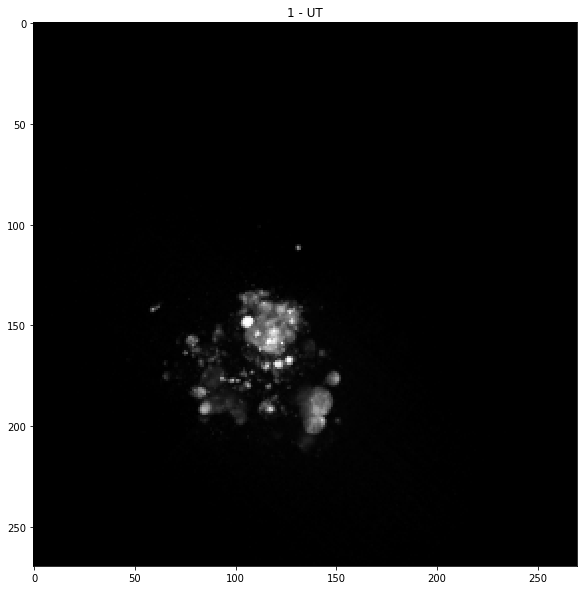

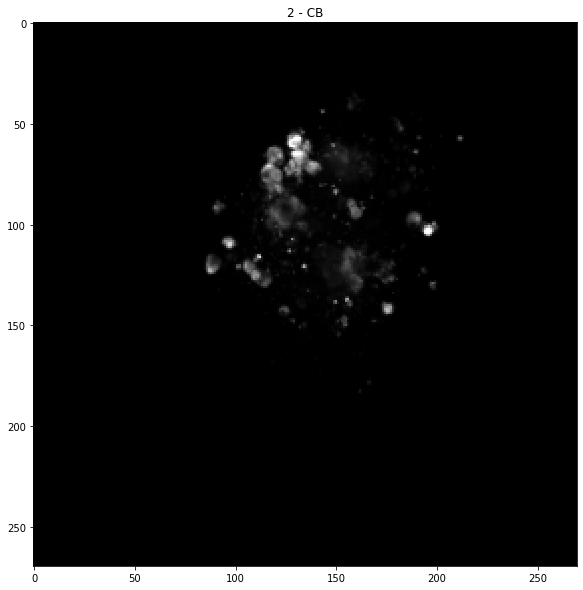

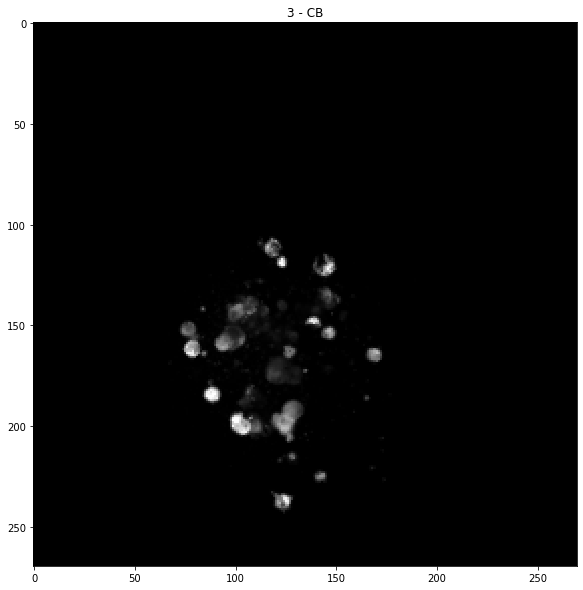

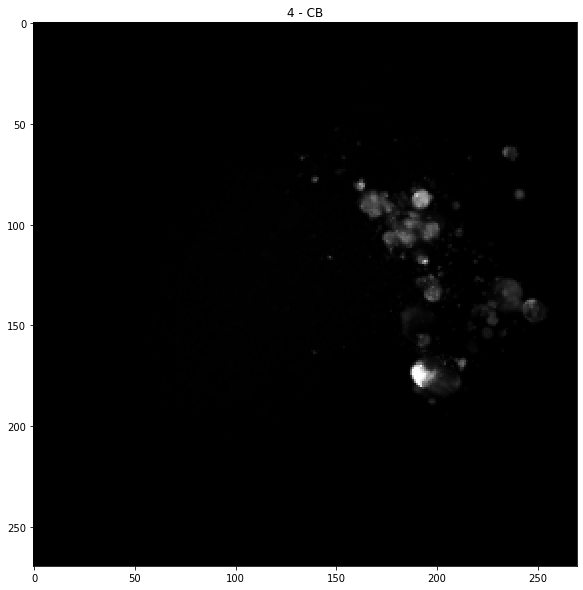

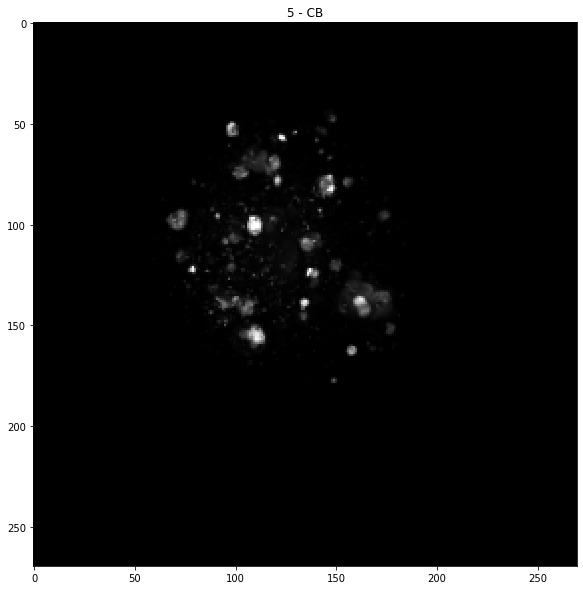

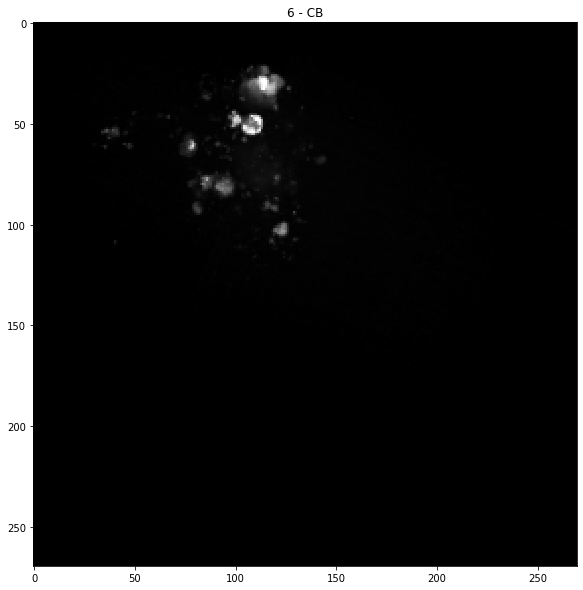

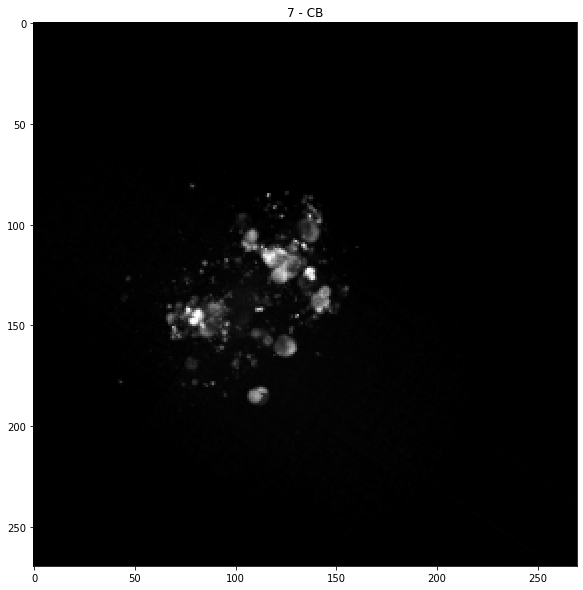

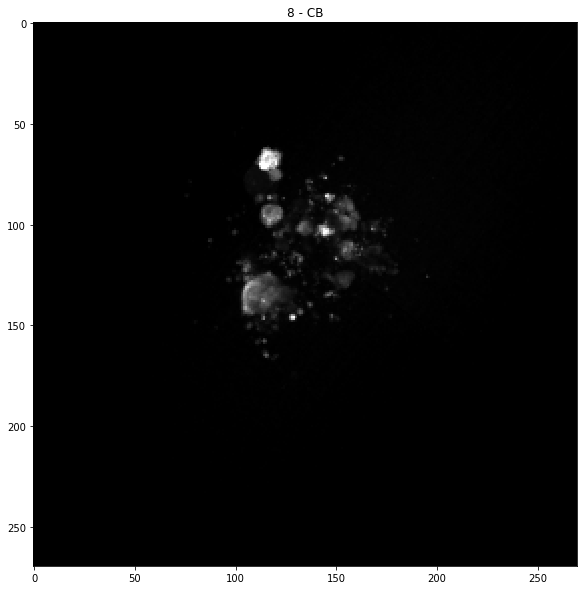

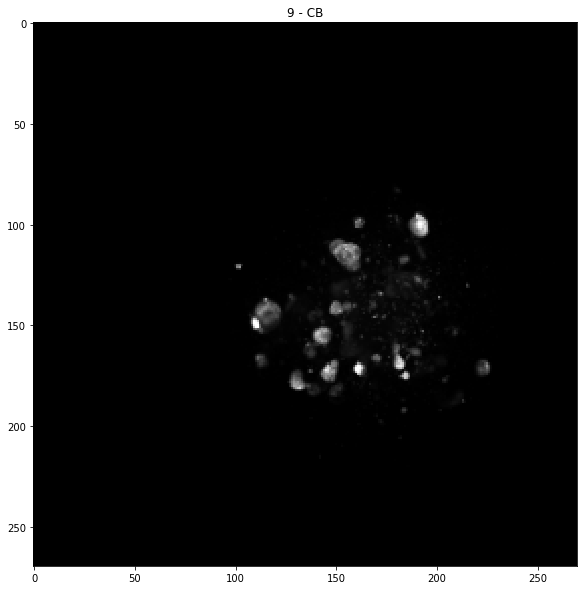

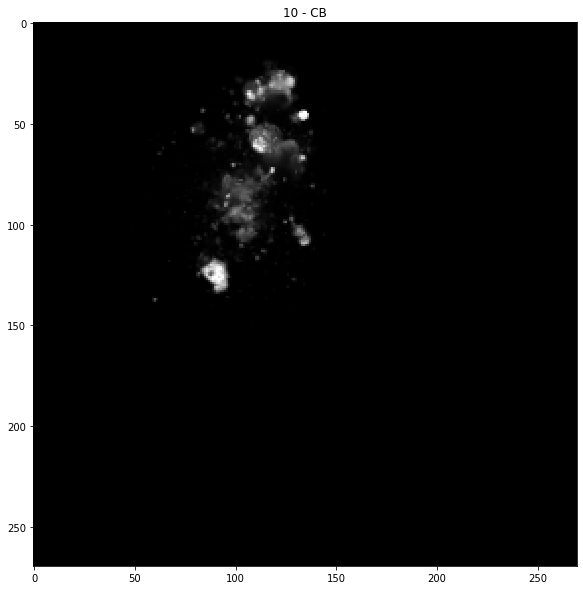

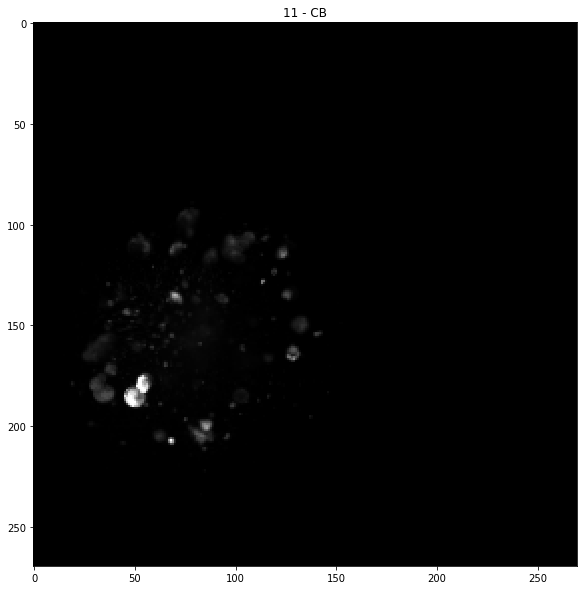

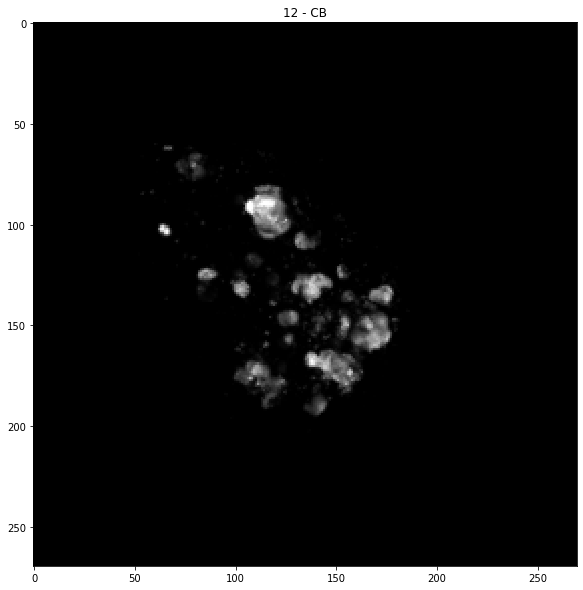

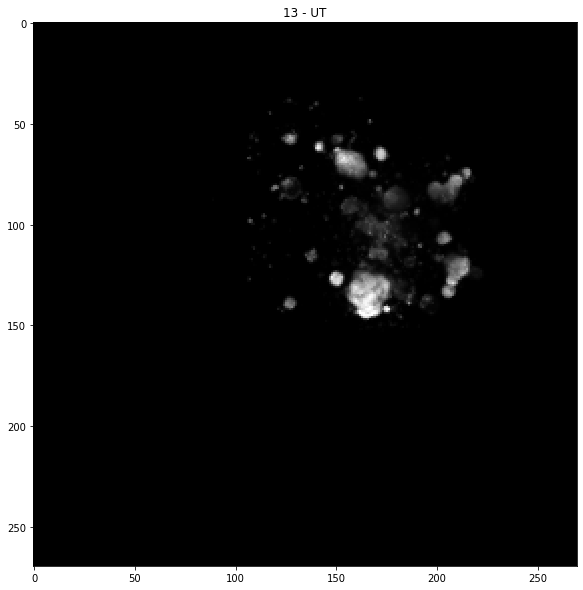

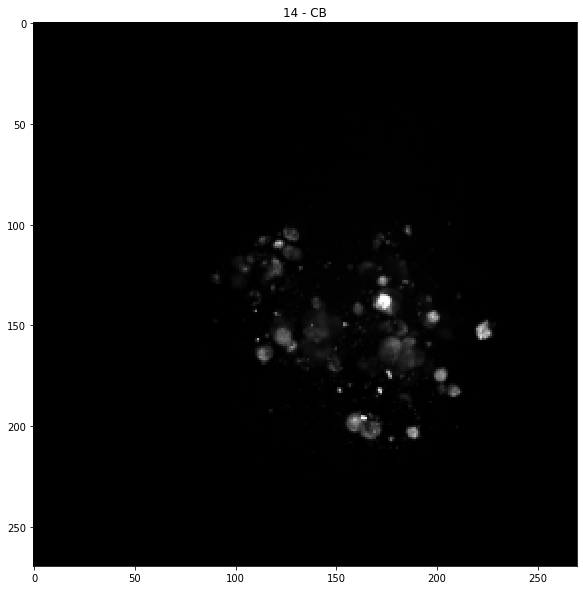

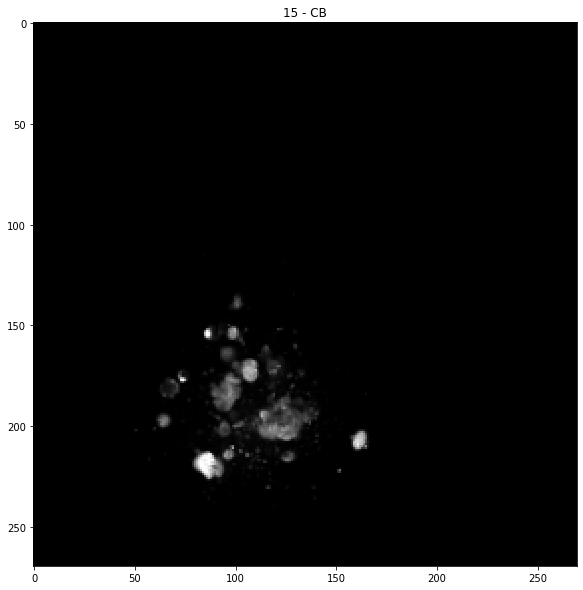

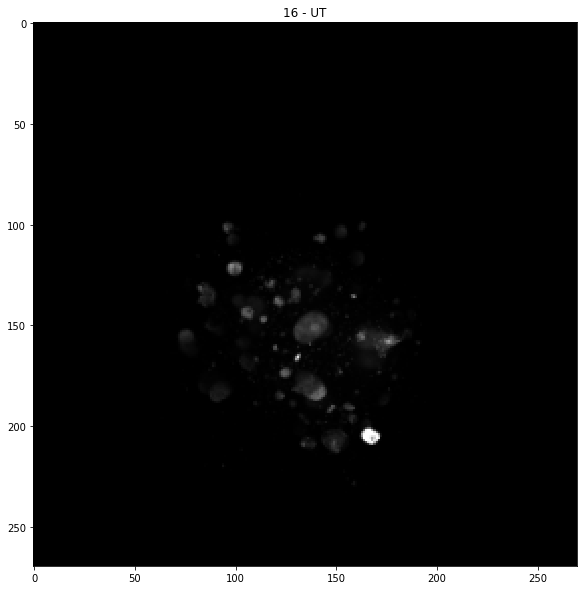

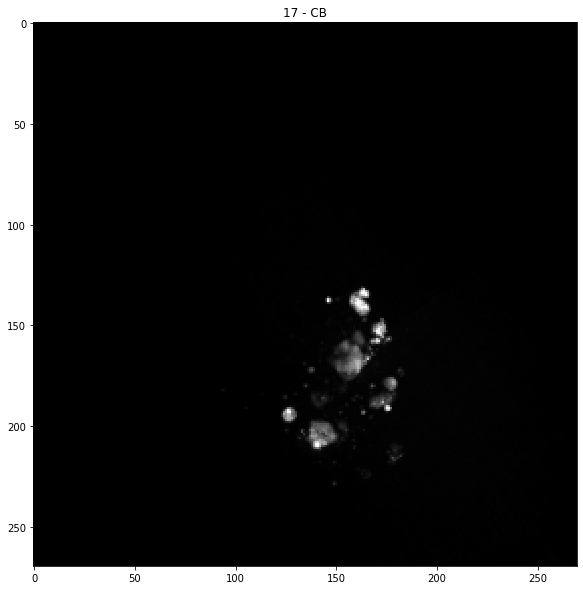

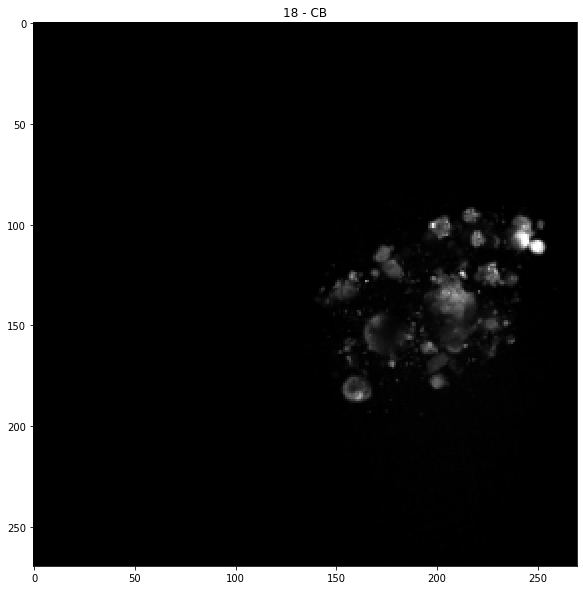

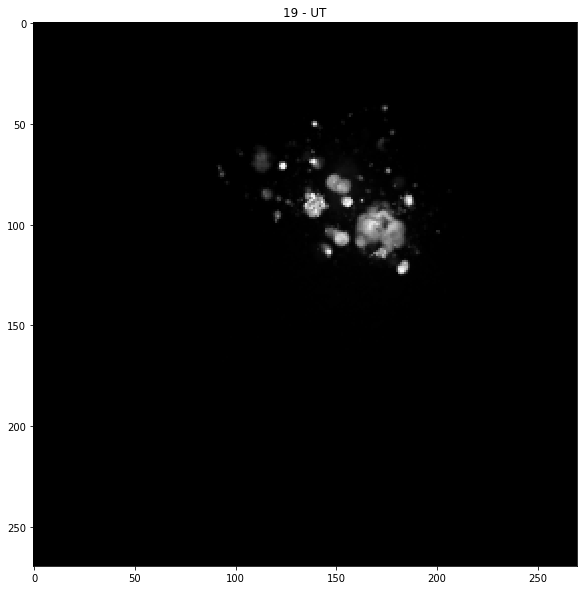

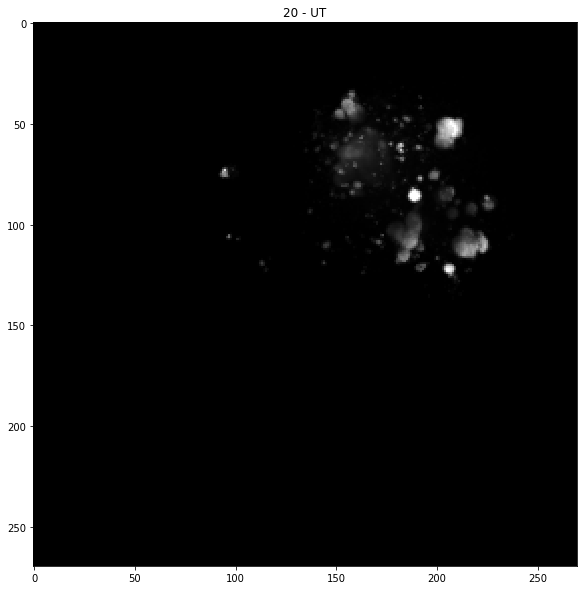

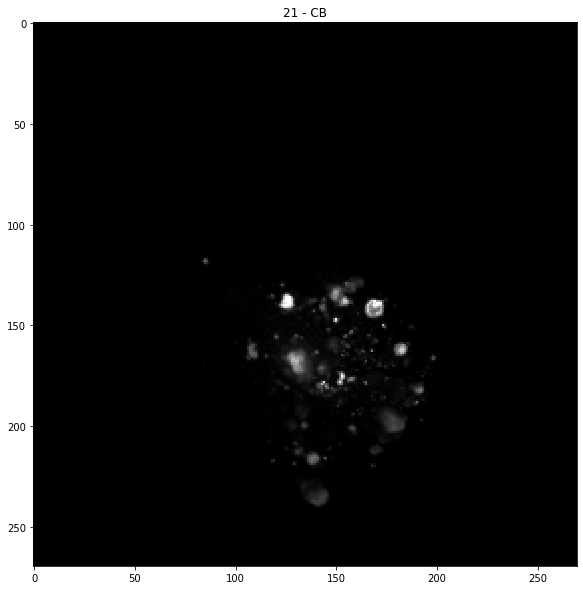

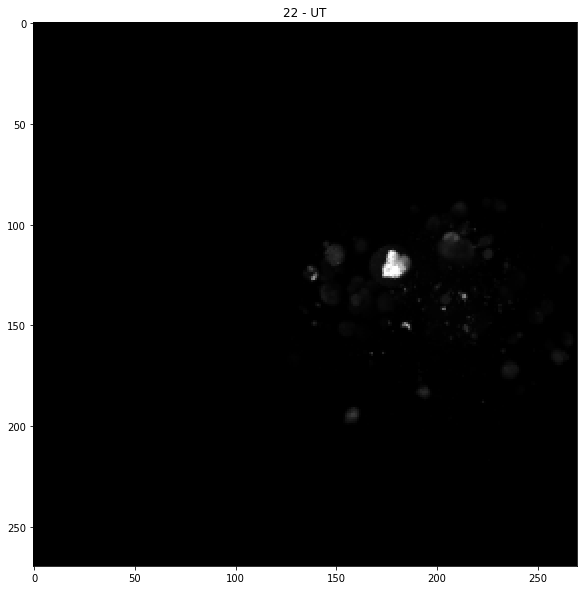

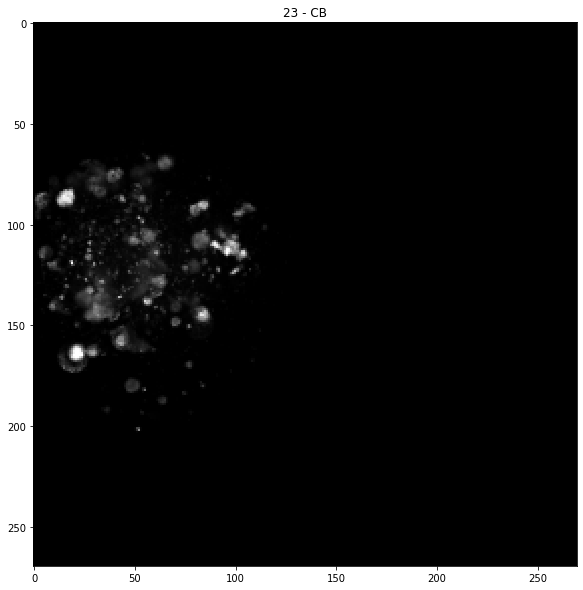

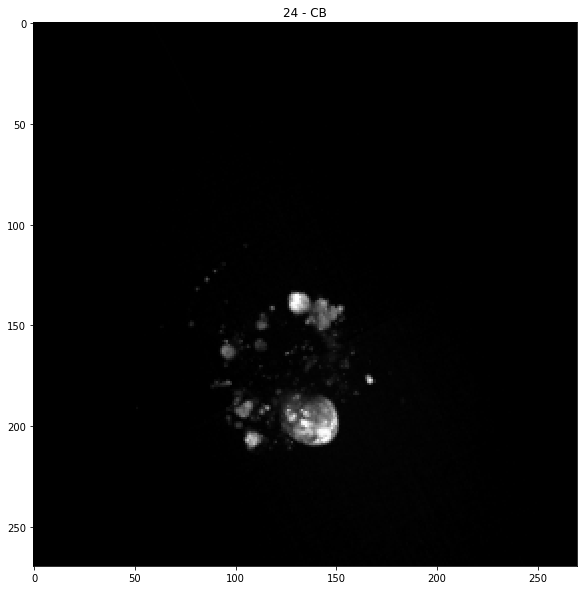

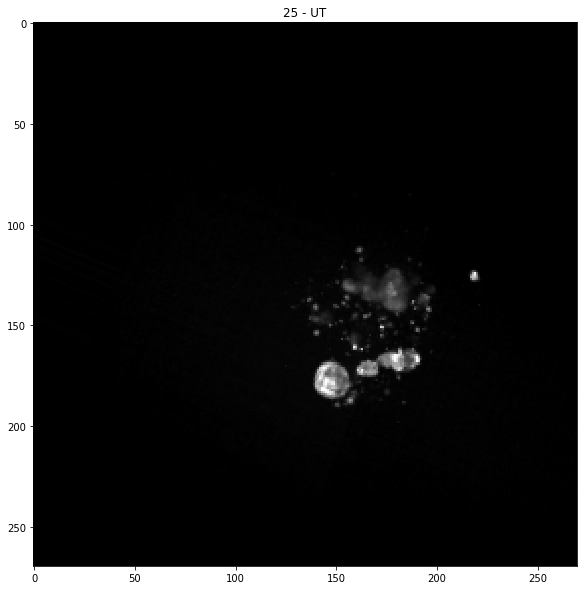

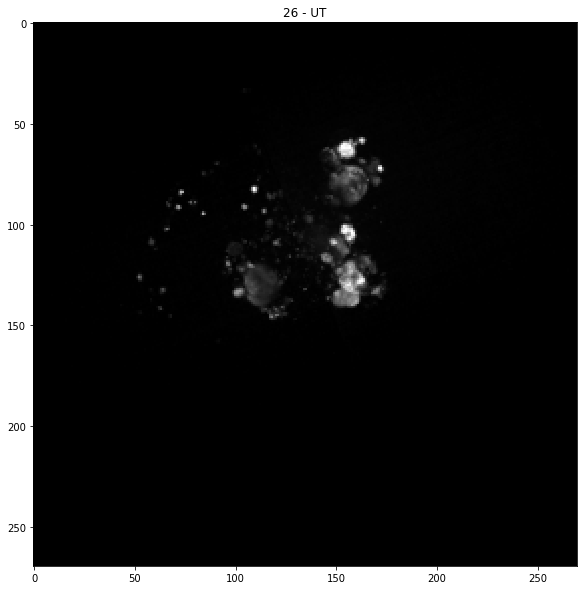

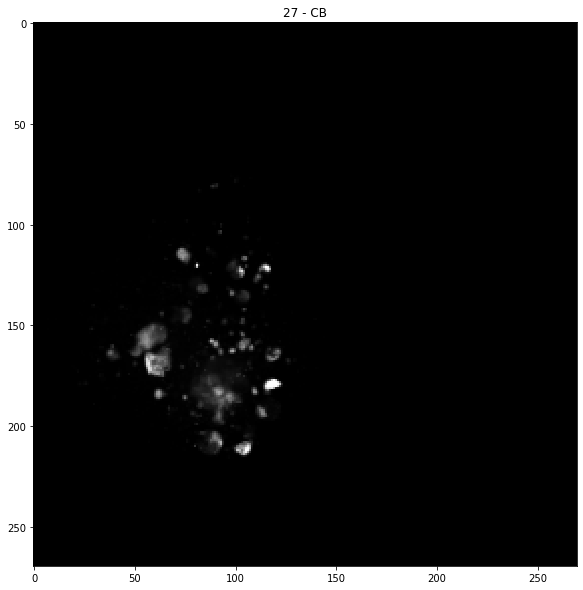

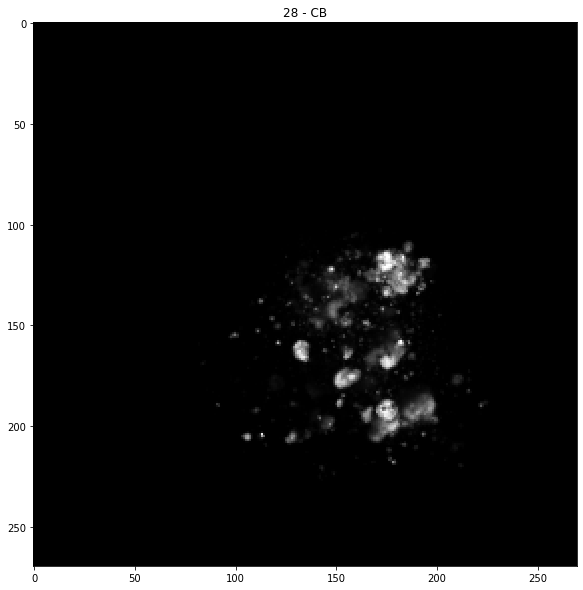

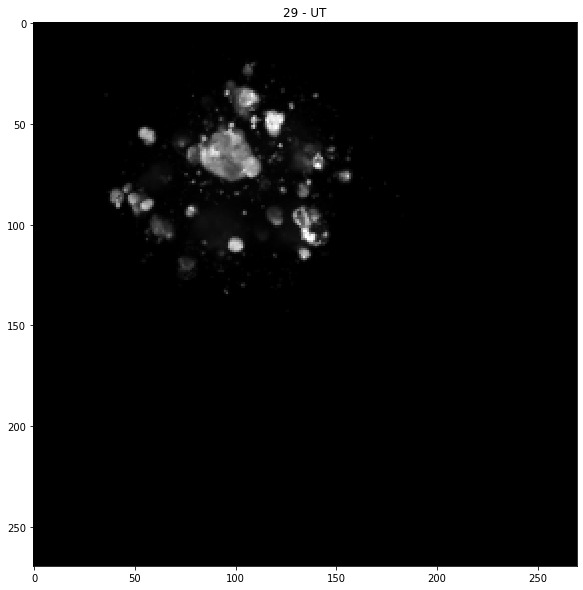

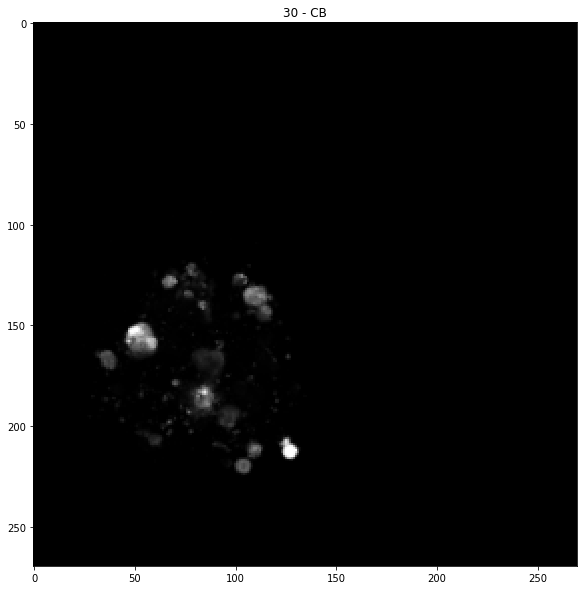

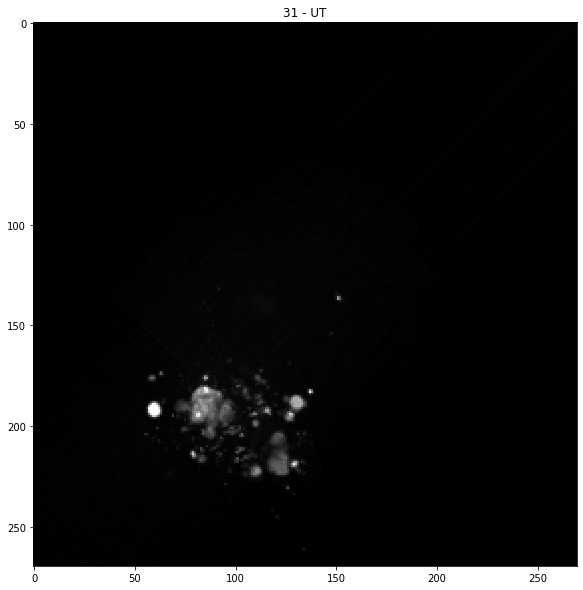

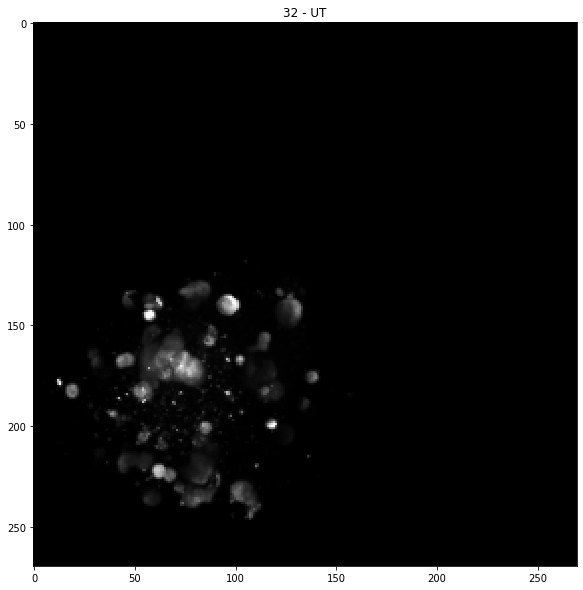

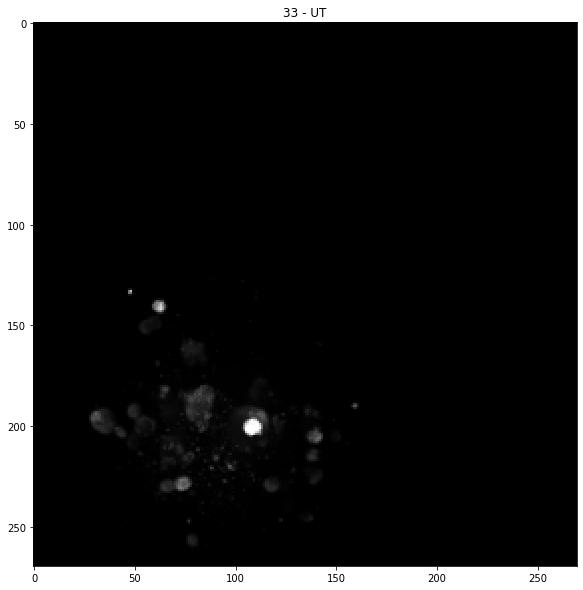

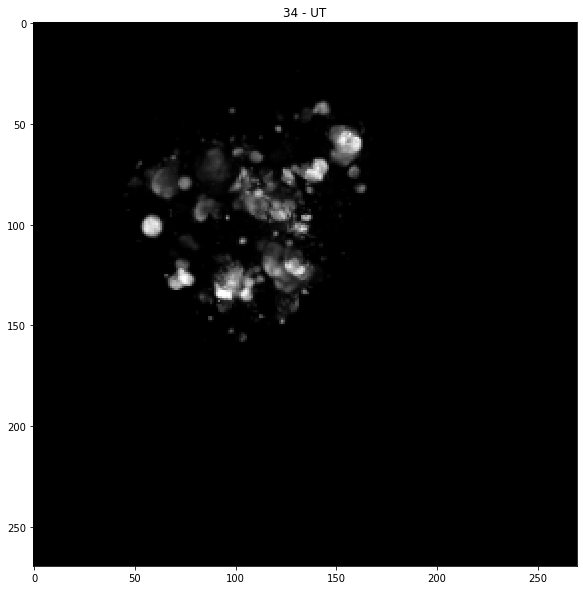

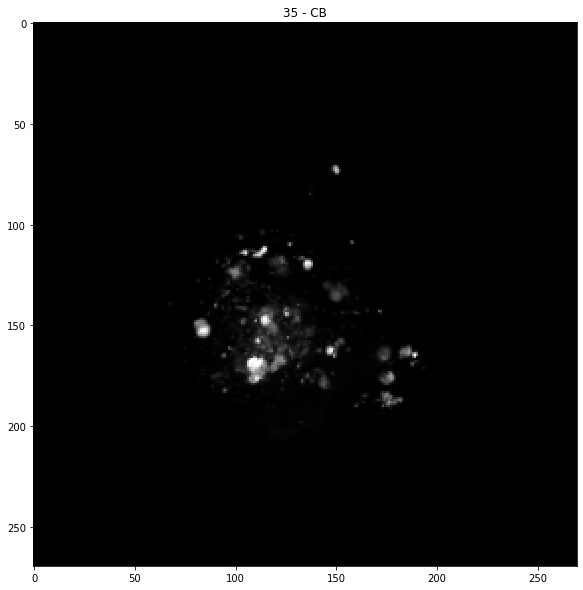

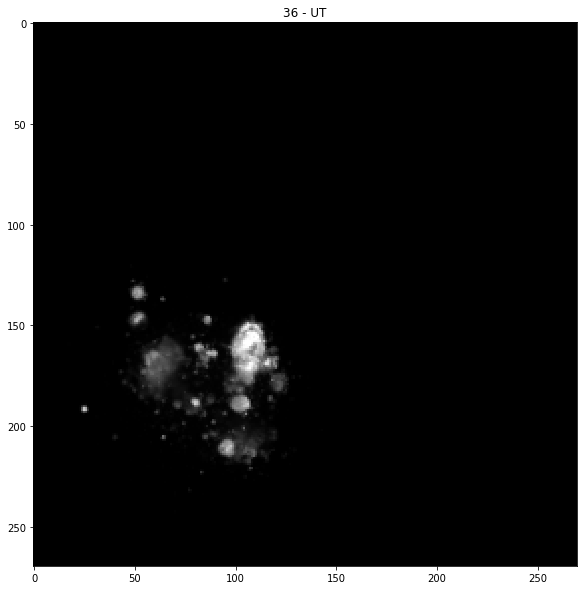

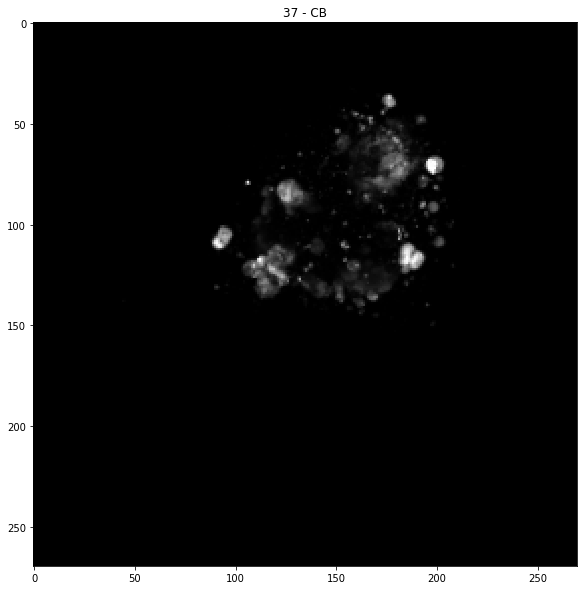

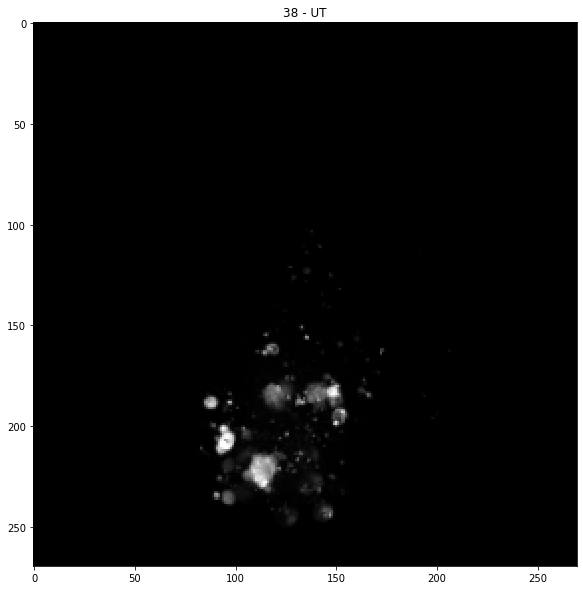

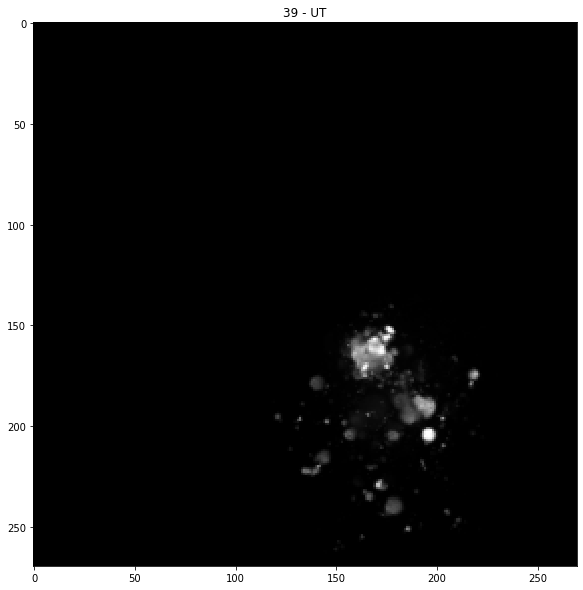

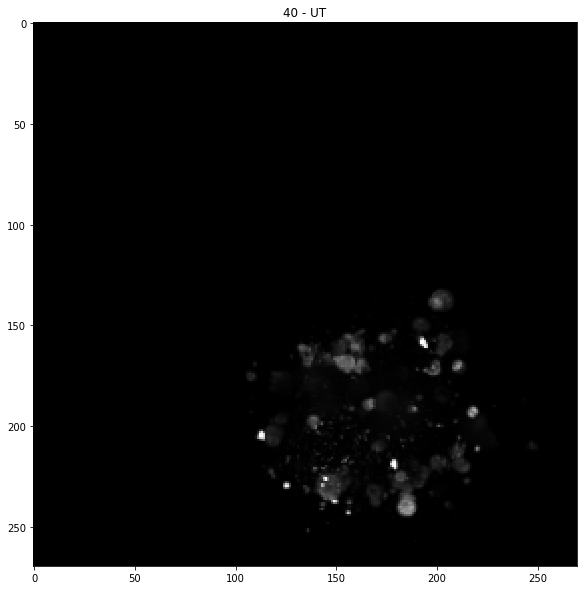

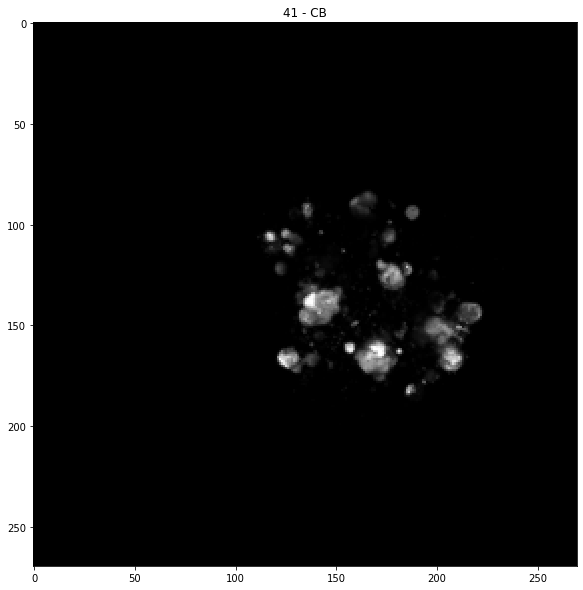

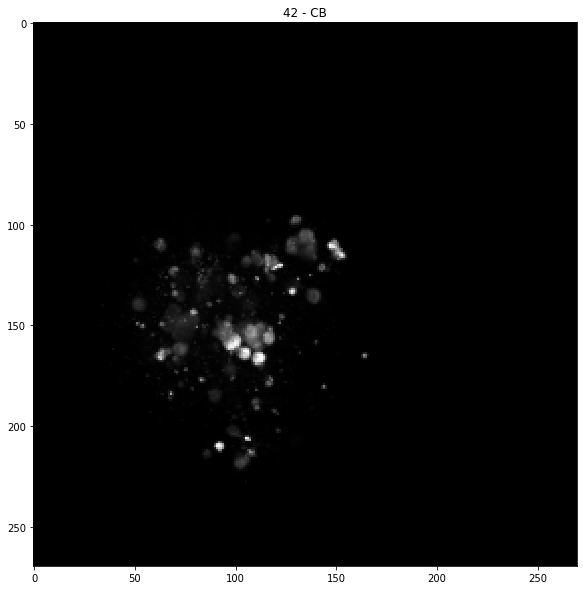

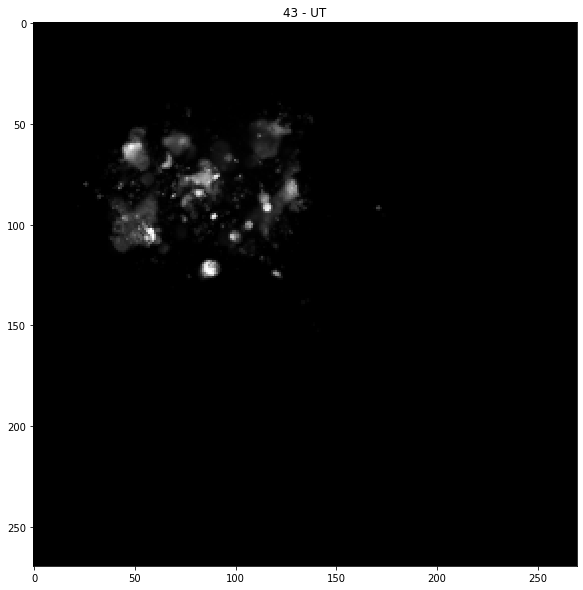

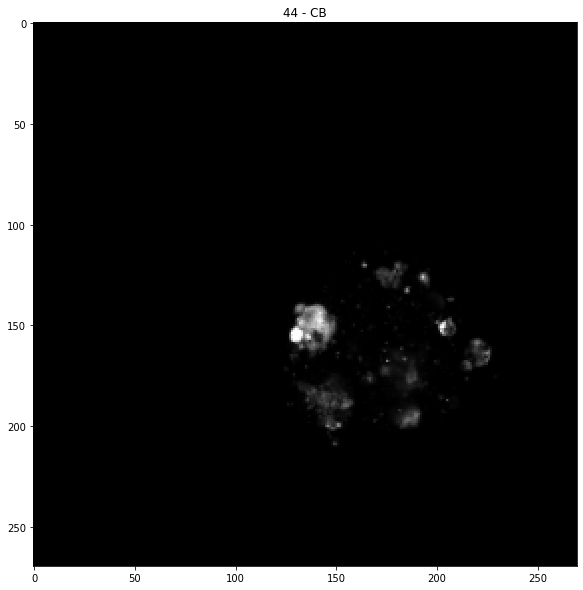

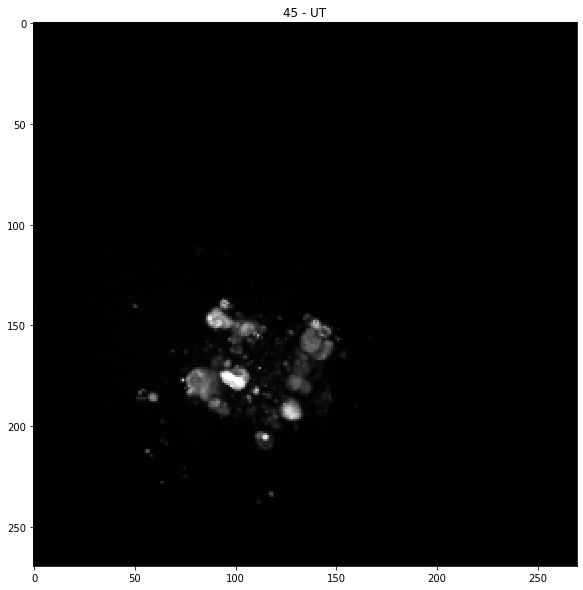

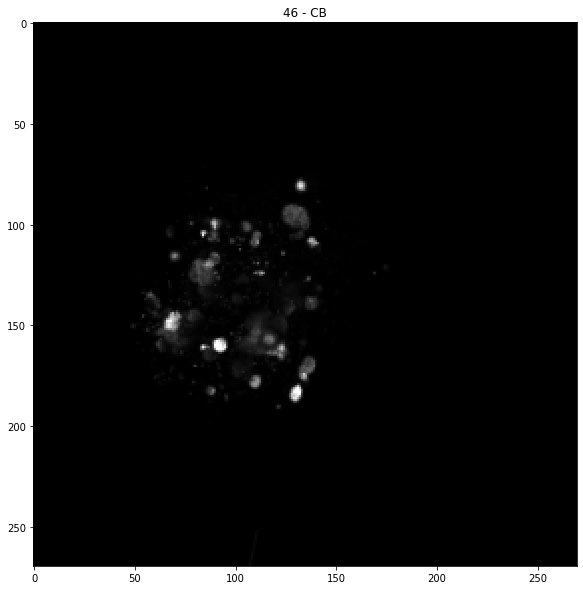

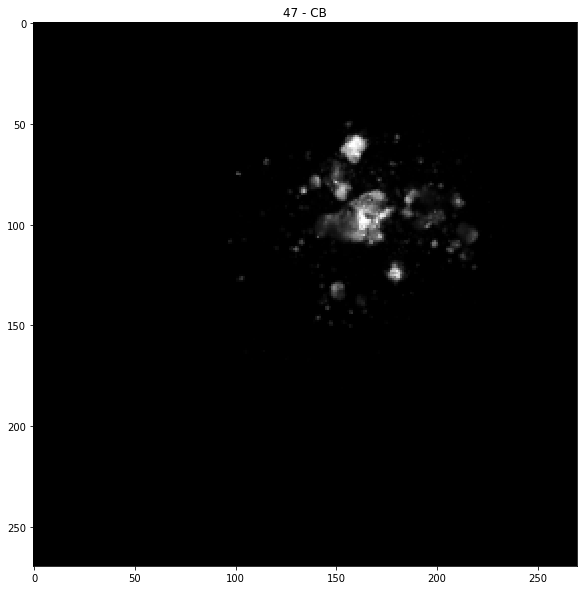

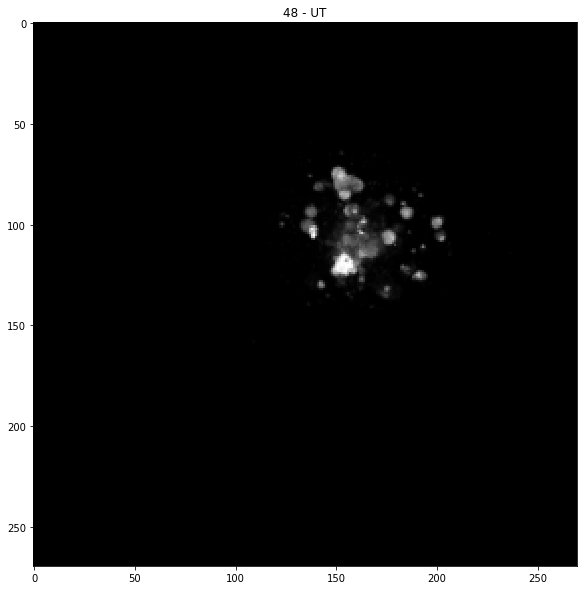

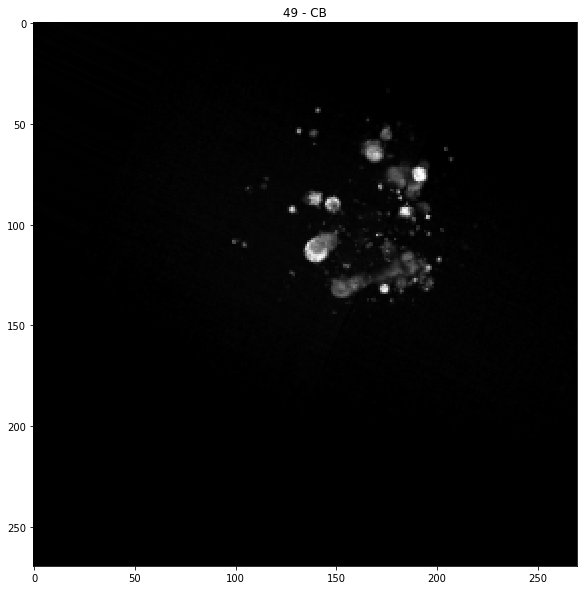

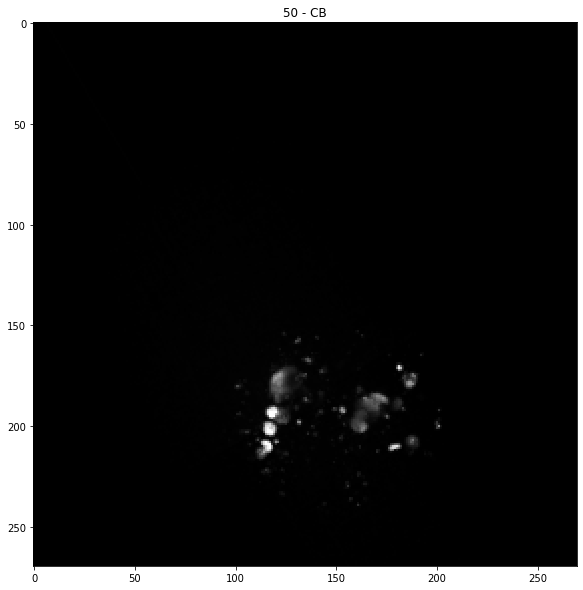

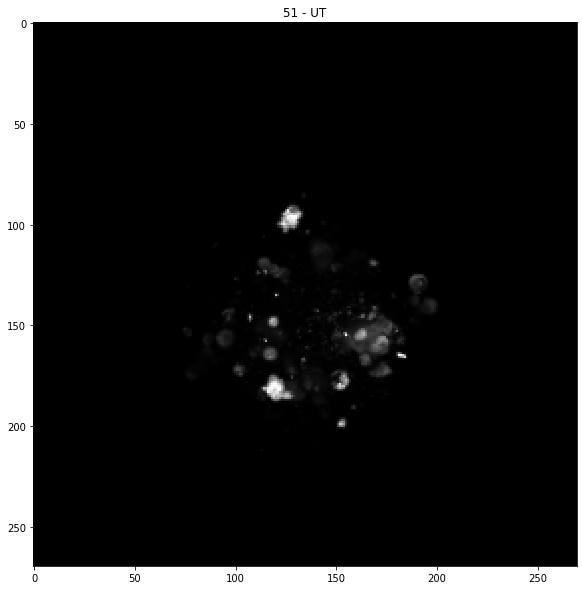

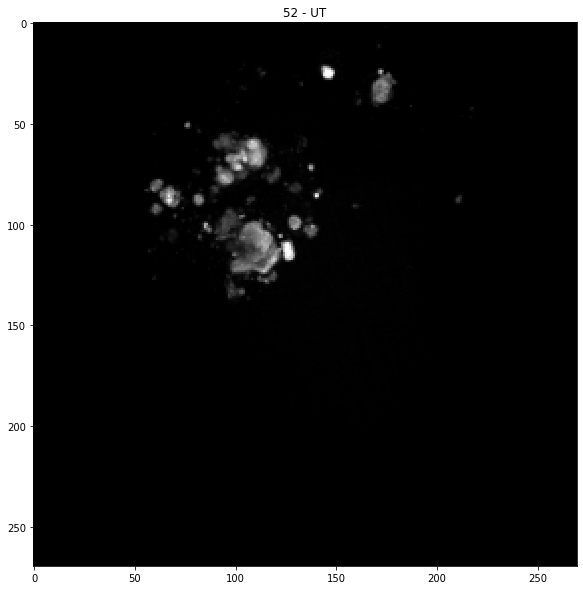

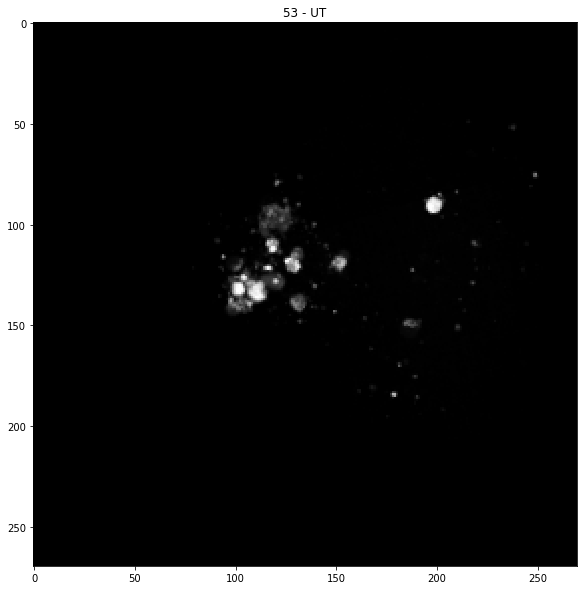

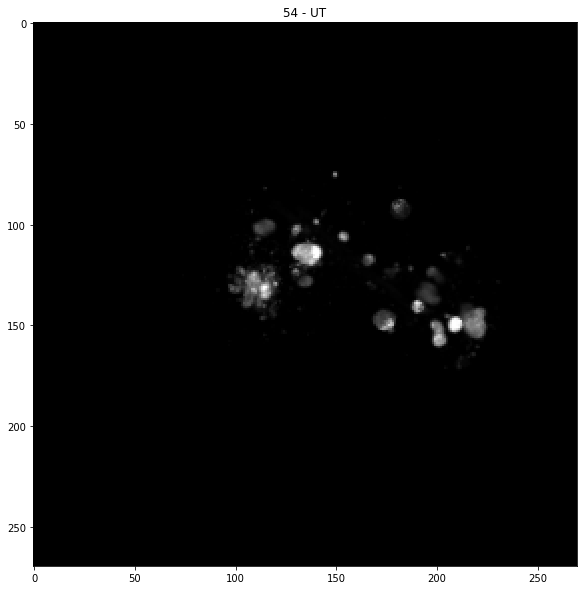

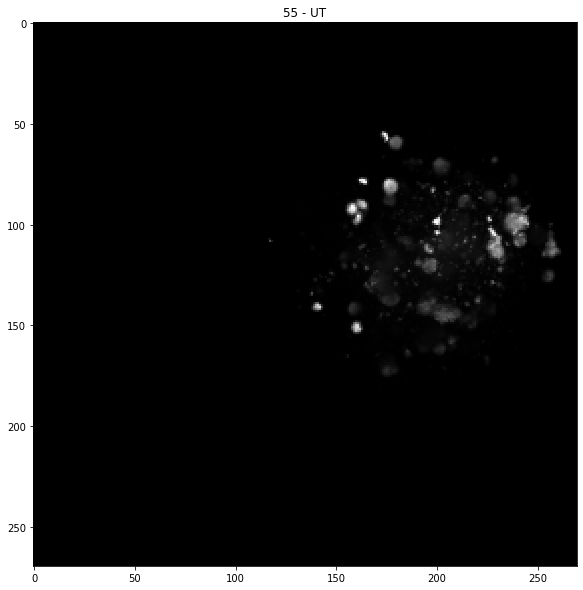

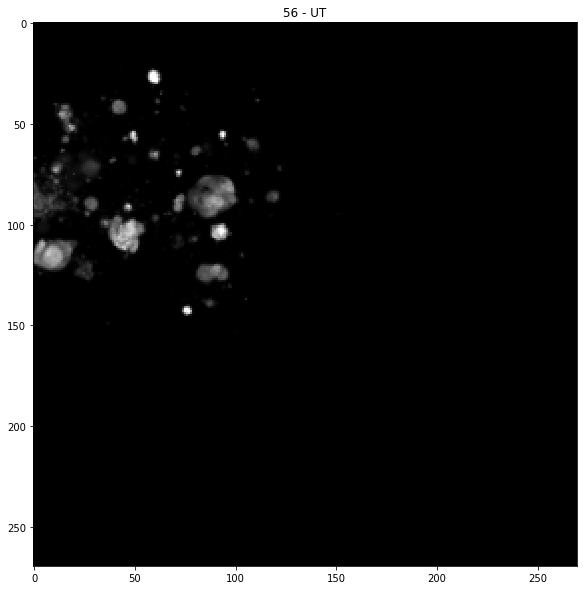

In [199]:
from matplotlib import pyplot as plt
count = 0 
for X_batch, y_batch in train_generator:
    
    if count > 50 : # stop after 50 images
        break
        
    # create a grid of 3x3 images
    for i in range(0, len(X_batch)):
        count+=1
        label = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(y_batch[i])]

        fig = plt.figure(figsize = (10,10))
        sp = fig.add_subplot(111)
        sp.set_title(str(count) + " - " + label)
        if CHANNELS == 1:
            sp.imshow(X_batch[i].reshape(IMAGE_SIZE,IMAGE_SIZE), interpolation='none',  cmap='gray')
        else:
            sp.imshow(X_batch[i].reshape(IMG_SHAPE), interpolation='none')

        # show the plot
        plt.show()


In [204]:
#create network
import tensorflow as tf

# Pre-trained model with MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained model weights
base_model.trainable = False
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
learning_rate = 0.0001
# Layer classification head with feature detector
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy']
)
         
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 9, 9, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [205]:
#Train network
from PIL import Image

num_epochs = 100
steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = validation_generator.n//validation_generator.batch_size

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=val_steps)

Train for 12 steps, validate for 5 steps
Epoch 1/100
12/12 [==============================] - 6s 474ms/step - loss: 2.9770 - accuracy: 0.4831 - val_loss: 2.8671 - val_accuracy: 0.4250
Epoch 2/100
12/12 [==============================] - 2s 170ms/step - loss: 0.9988 - accuracy: 0.5843 - val_loss: 2.0716 - val_accuracy: 0.4000
Epoch 3/100
12/12 [==============================] - 2s 171ms/step - loss: 1.2666 - accuracy: 0.5506 - val_loss: 2.2713 - val_accuracy: 0.4250
Epoch 4/100
12/12 [==============================] - 2s 172ms/step - loss: 1.0948 - accuracy: 0.5393 - val_loss: 2.2259 - val_accuracy: 0.4250
Epoch 5/100
12/12 [==============================] - 2s 171ms/step - loss: 1.0862 - accuracy: 0.5169 - val_loss: 2.4892 - val_accuracy: 0.4500
Epoch 6/100
12/12 [==============================] - 2s 171ms/step - loss: 1.1010 - accuracy: 0.4944 - val_loss: 2.4385 - val_accuracy: 0.4500
Epoch 7/100
12/12 [==============================] - 2s 169ms/step - loss: 1.1996 - accuracy: 0.4831 

Epoch 58/100
12/12 [==============================] - 2s 171ms/step - loss: 0.9044 - accuracy: 0.5506 - val_loss: 1.9292 - val_accuracy: 0.4500
Epoch 59/100
12/12 [==============================] - 2s 169ms/step - loss: 1.1114 - accuracy: 0.5281 - val_loss: 2.1620 - val_accuracy: 0.4500
Epoch 60/100
12/12 [==============================] - 2s 173ms/step - loss: 1.0863 - accuracy: 0.5506 - val_loss: 2.0199 - val_accuracy: 0.4750
Epoch 61/100
12/12 [==============================] - 2s 172ms/step - loss: 0.8142 - accuracy: 0.6854 - val_loss: 2.2485 - val_accuracy: 0.4750
Epoch 62/100
12/12 [==============================] - 2s 171ms/step - loss: 0.7507 - accuracy: 0.7079 - val_loss: 2.2320 - val_accuracy: 0.4500
Epoch 63/100
12/12 [==============================] - 2s 169ms/step - loss: 1.2446 - accuracy: 0.5056 - val_loss: 1.8266 - val_accuracy: 0.3750
Epoch 64/100
12/12 [==============================] - 2s 172ms/step - loss: 1.1050 - accuracy: 0.5506 - val_loss: 1.9749 - val_accuracy:

In [206]:
# Save model weights
model.save_weights(output +'weights.h5')

#model. get_weights()  # for checking weights

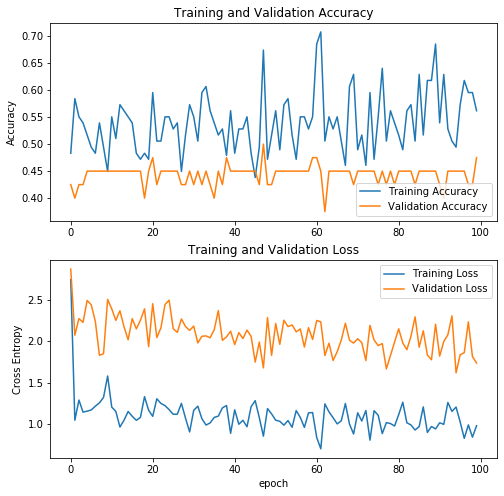

In [207]:
# plot training

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(output +'plot.pdf') as pdf:
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    pdf.savefig();
    plt.show()
    plt.close()

In [208]:
#predict test_data

def probas_to_classes(y_pred):
    return np.array([1 if p > 0.5 else 0 for p in y_pred])

#create Image generator
datagen_test = ImageDataGenerator(
        rescale=1./255)  # set values to 0-1

#Note. not sure if these have to be reshuffled during iterations
#create generator for training data
test_generator = datagen_test.flow_from_dataframe(
        dataframe=df_test,
        x_col="filename",
        y_col="class",
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle = False,
        color_mode = 'grayscale' if CHANNELS == 1 else 'rgb' )

# run testdata
prediction = model.predict(test_generator)
pred_classes = probas_to_classes(prediction)

print(test_generator.class_indices)

for i in range(0,len(prediction)):
    pred_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(pred_classes[i])]
    print(test_filenames[i] + ' - ' + test_labels[i] + ' - ' + str(prediction[i])+ ' - pred: ' + pred_class)

Found 16 validated image filenames belonging to 2 classes.
{'CB': 0, 'UT': 1}
D:\work\48h_output\max\ch3\015.png - CB - [0.9706472] - pred: UT
D:\work\48h_output\max\ch3\162.png - UT - [0.92173254] - pred: UT
D:\work\48h_output\max\ch3\220.png - UT - [0.9736472] - pred: UT
D:\work\48h_output\max\ch3\173.png - UT - [0.95838654] - pred: UT
D:\work\48h_output\max\ch3\177.png - UT - [0.9272237] - pred: UT
D:\work\48h_output\max\ch3\065.png - CB - [0.9514954] - pred: UT
D:\work\48h_output\max\ch3\018.png - CB - [0.99706864] - pred: UT
D:\work\48h_output\max\ch3\045.png - CB - [0.9741558] - pred: UT
D:\work\48h_output\max\ch3\036.png - CB - [0.9653702] - pred: UT
D:\work\48h_output\max\ch3\055.png - CB - [0.96642697] - pred: UT
D:\work\48h_output\max\ch3\153.png - UT - [0.9865571] - pred: UT
D:\work\48h_output\max\ch3\210.png - UT - [0.9667902] - pred: UT
D:\work\48h_output\max\ch3\019.png - CB - [0.96081406] - pred: UT
D:\work\48h_output\max\ch3\215.png - UT - [0.9904015] - pred: UT
D:\work